## About the Dataset

This project utilizes three separate CSV files containing information on airlines, airports, and routes compiled by OpenFlights, which offers a comprehensive view of global air travel. The Airports file included location details such as IATA and ICAO codes, country, and geographic coordinates. The Airlines file provided airline names, codes, countries of operation, and operational status. The Routes file listed direct flight connections between airports along with the corresponding operating airline.

## Business task

The business task is to identify the most connected airports and airlines worldwide, analyze long flight distances, and uncover geographic patterns that could inform strategic partnerships or infrastructure investments.

## Questions for Analysis
* Which airport and airlines dominate global connectivity
* What are the shortest/longest average routes?
* How does connectivity vary by continent or country?
* Are there mismatches between dataset values and real-world flight volumes, and what do those say about data reliability?

## Data Preparation

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry_convert as pc

### Importing Datasets

In [86]:
airplanes = pd.read_csv("airplanes.csv")
airlines = pd.read_csv("airlines.csv")
airports = pd.read_csv('airports.csv')
routes = pd.read_csv("routes.csv")

### Data Cleaning

In [87]:
print(f"The Airlines dataset contains {airlines.shape[0]} rows and {airlines.shape[1]} columns.")
print(f"The airports dataset contains {airports.shape[0]} rows and {airports.shape[1]} columns.")
print(f"The routes dataset contains {routes.shape[0]} rows and {routes.shape[1]} columns.")

The Airlines dataset contains 6162 rows and 8 columns.
The airports dataset contains 7698 rows and 14 columns.
The routes dataset contains 67663 rows and 9 columns.


In [88]:
# Show raw structure (first 2 rows)
display(airports.head(2))
display(airlines.head(2))
display(routes.head(2))

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.08169,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.20708,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports


,Airline ID,Name,Alias,IATA,ICAO,Callsign,Country,Active
0,-1,Unknown,\N,-,NaN,\N,\N,Y
1,1,Private flight,\N,-,NaN,NaN,NaN,Y


,Airline,Airline ID,Source airport,Source airport ID,Destination airport,Destination airport ID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2


I will be exploring and cleaning each dataset individually before performing any merging. This ensures data quality, consistency, and a better understanding of each dataset’s structure before combining them.

In [89]:
### Routes dataset
print(routes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67663 entries, 0 to 67662
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Airline                 67663 non-null  object
 1   Airline ID              67663 non-null  object
 2   Source airport          67663 non-null  object
 3   Source airport ID       67663 non-null  object
 4   Destination airport     67663 non-null  object
 5   Destination airport ID  67663 non-null  object
 6   Codeshare               14597 non-null  object
 7   Stops                   67663 non-null  int64 
 8   Equipment               67645 non-null  object
dtypes: int64(1), object(8)
memory usage: 4.6+ MB
None


In [90]:
# Replace '\N' with np.nan across the entire DataFrame
routes.replace('\\N', np.nan, inplace=True)

print(routes.isna().sum())

Airline                       0
Airline ID                  479
Source airport                0
Source airport ID           220
Destination airport           0
Destination airport ID      221
Codeshare                 53066
Stops                         0
Equipment                    18
dtype: int64


I decided to drop the columns `Codeshare`, `Stops`, and `Equipment` because they do not affect the airport connnectivitiy and airline route coverage analysis in this project.

In [91]:
#drop unneeded columns and rows with missing values
routes = routes.drop(['Codeshare', 'Stops','Equipment'], axis=1).dropna(
    subset=['Source airport ID', 'Destination airport ID', 'Airline ID']
)

In [92]:
routes.isnull().sum()

Airline                   0
Airline ID                0
Source airport            0
Source airport ID         0
Destination airport       0
Destination airport ID    0
dtype: int64

In [93]:
routes['Airline ID'] = pd.to_numeric(routes['Airline ID'], errors='coerce').astype('Int64')
routes['Source airport ID'] = pd.to_numeric(routes['Source airport ID'], errors='coerce').astype('Int64')

In [94]:
# airports
airports = airports.drop(['ICAO', 'Timezone', 'DST','Tz database time zone', 'Type', 'Source'], axis = 1)

In [95]:
airports.isnull().sum()

Airport ID     0
Name           0
City          49
Country        0
IATA           0
Latitude       0
Longitude      0
Altitude       0
dtype: int64

In [96]:
# Replace '\N' with np.nan accross the entire DataFrame
airports.replace('\\N', np.nan, inplace=True)

print(airports.isnull().sum())

Airport ID       0
Name             0
City            49
Country          0
IATA          1626
Latitude         0
Longitude        0
Altitude         0
dtype: int64


In [97]:
airports = airports.dropna(subset=['IATA'])
airports = airports.dropna(subset=['City'])
print(airports.isnull().sum())

Airport ID    0
Name          0
City          0
Country       0
IATA          0
Latitude      0
Longitude     0
Altitude      0
dtype: int64


In [98]:
# Replace '\N' with np.nan accross the entire DataFrame
airlines.replace('\\N', np.nan, inplace=True)

print(airlines.isnull().sum())

Airline ID       0
Name             0
Alias         5984
IATA          4628
ICAO           275
Callsign       811
Country         18
Active           0
dtype: int64


In [99]:
airlines = airlines.drop(['Alias', 'IATA','ICAO','Callsign',], axis=1)

In [100]:
airlines = airlines.dropna(subset=['Country'])

In [101]:
airlines.isnull().sum()

Airline ID    0
Name          0
Country       0
Active        0
dtype: int64

## Exploratory Analysis

### Airport Connectivity
#### What airports had the most flights?

In [102]:
airports_flights = (
    pd.concat([
        routes['Source airport'],
        routes['Destination airport']
    ])
    .value_counts()
    .rename_axis('Airport')
    .reset_index(name = 'Total Flights')
    .sort_values(by = 'Total Flights', ascending = False)
    .merge(airports[['IATA','Name','Country','City','Latitude','Longitude']],
          left_on = 'Airport', right_on = 'IATA')
)
airports_flights.head(10)

,Airport,Total Flights,IATA,Name,Country,City,Latitude,Longitude
0,ATL,1826,ATL,Hartsfield Jackson Atlanta International Airport,United States,Atlanta,33.636700,-84.428101
1,ORD,1108,ORD,Chicago O'Hare International Airport,United States,Chicago,41.978600,-87.904800
2,PEK,1069,PEK,Beijing Capital International Airport,China,Beijing,40.080101,116.584999
3,LHR,1047,LHR,London Heathrow Airport,United Kingdom,London,51.470600,-0.461941
4,CDG,1041,CDG,Charles de Gaulle International Airport,France,Paris,49.012798,2.550000
5,FRA,990,FRA,Frankfurt am Main Airport,Germany,Frankfurt,50.033333,8.570556
6,LAX,990,LAX,Los Angeles International Airport,United States,Los Angeles,33.942501,-118.407997
7,DFW,936,DFW,Dallas Fort Worth International Airport,United States,Dallas-Fort Worth,32.896801,-97.038002
8,JFK,911,JFK,John F Kennedy International Airport,United States,New York,40.639801,-73.778900
9,AMS,903,AMS,Amsterdam Airport Schiphol,Netherlands,Amsterdam,52.308601,4.763890


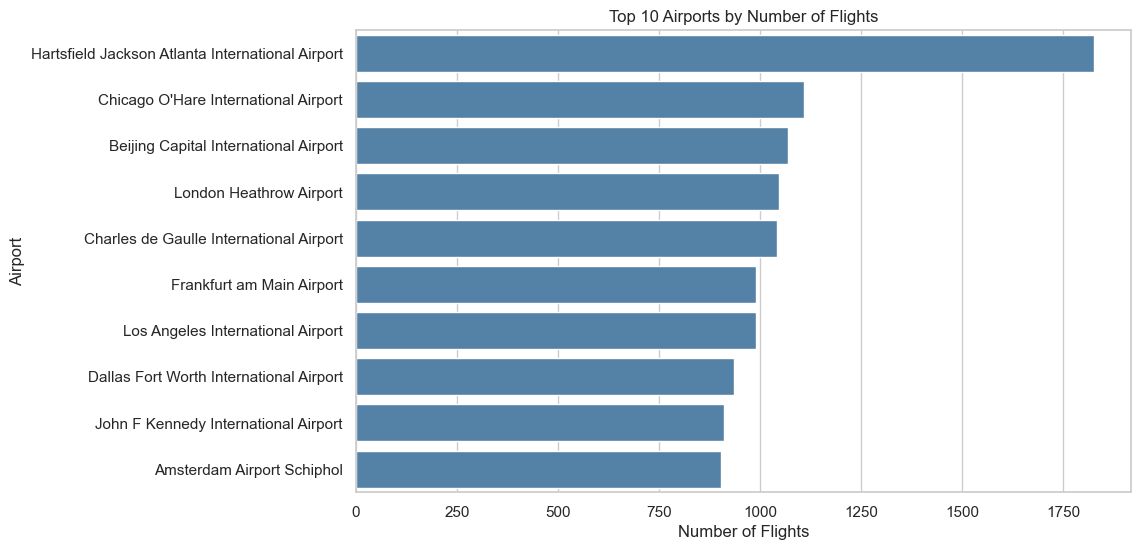

In [103]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(
    y='Name',
    x='Total Flights',
    data=airports_flights.head(10),
    color='steelblue'
)

plt.title('Top 10 Airports by Number of Flights')
plt.xlabel('Number of Flights')
plt.ylabel('Airport')
plt.show()

ATL dominates global connectivity, consistent with its real-world role as one of the busiest hubs, though the absolute numbers are lower than 2024 traffic — a dataset limitation.

### Airport Diveristy of Connections
#### Which airports connect to the most unique destinations?

In [104]:
# The number of unique destinations per airport
airport_dest_count = (routes.groupby('Source airport')['Destination airport']
               .nunique()
               .reset_index()
               .rename(columns = {'Destination airport': 'Num Unique Destinations'})
               .sort_values(by = 'Num Unique Destinations', ascending = False)
               .merge(airports[['IATA','Name','Country','City','Latitude','Longitude']],
                         left_on = 'Source airport', right_on = 'IATA'))

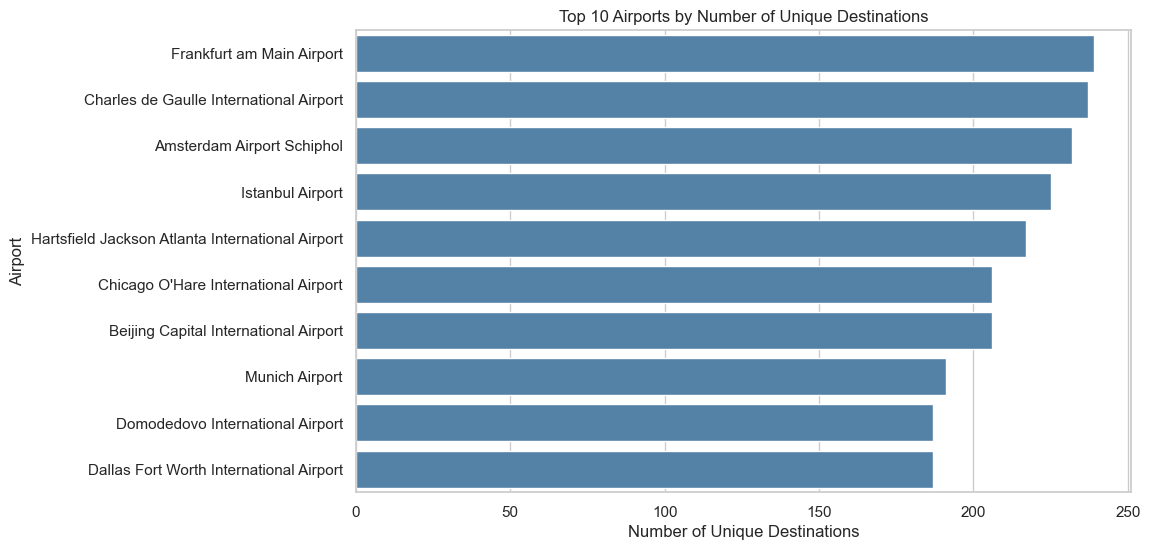

In [105]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(
    y='Name', 
    x='Num Unique Destinations', 
    data=airport_dest_count.head(10),
    color='steelblue'
)

plt.title('Top 10 Airports by Number of Unique Destinations')
plt.xlabel('Number of Unique Destinations')
plt.ylabel('Airport')
plt.show()

When merging the routes and airports datasets, I used an inner join to ensure that only airports with valid metadata (e.g., Name, Country, City) were included. A left join would have kept all source airports, but it would also have introduced missing values for airports not found in the reference airports table. Since the visualization requires clean airport names, the inner join was appropriate here. For completeness, I also inspected the unmatched airports using a left join, which revealed ~111 codes missing from the airports dataset

European hubs dominate in terms of unique destinations, reflecting their role as international transfer points

### Airline Connectivity
#### Which airlines serve the most unique destinations?

In [106]:
# Airlines with most unique destinations
unique_dest_airlines = (
    routes.groupby('Airline ID')['Destination airport']
    .nunique()
    .reset_index(name='Unique Destinations')
    .merge(airlines, on='Airline ID')
    .sort_values('Unique Destinations', ascending=False)
)

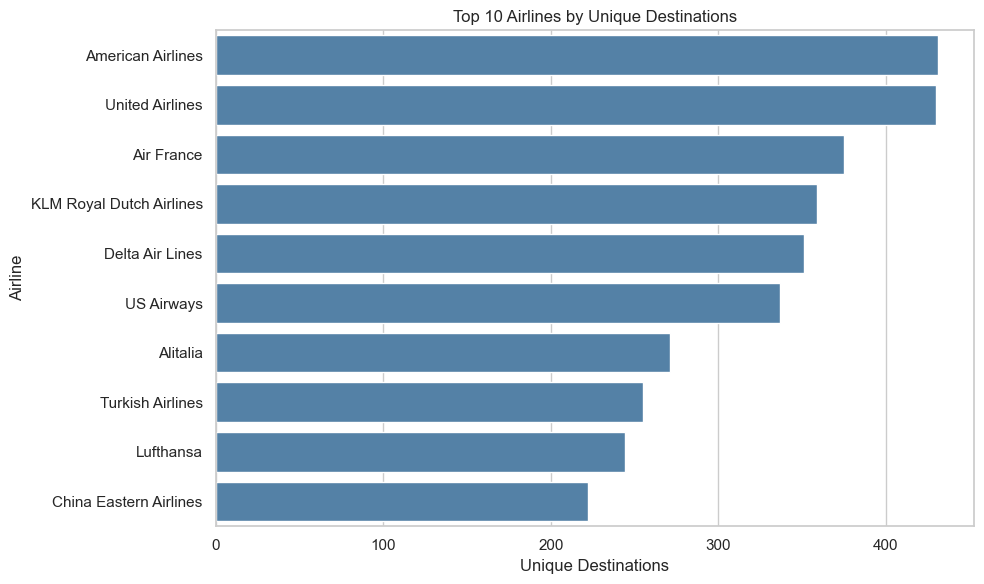

In [107]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
sns.barplot(
    data=unique_dest_airlines.head(10),
    y='Name',
    x='Unique Destinations',
    color='steelblue'
)

plt.title('Top 10 Airlines by Unique Destinations')
plt.xlabel('Unique Destinations')
plt.ylabel('Airline')
plt.tight_layout()
plt.show()

#### Which airlines operate the most flights?

In [108]:
top_airlines_by_flights = (
    routes['Airline ID'].value_counts()
    .reset_index()
    .rename(columns = {'count': 'Total Flights'})
    .merge(airlines, on = 'Airline ID')
)
top_airlines_by_flights.head(10)

,Airline ID,Total Flights,Name,Country,Active
0,4296,2484,Ryanair,Ireland,Y
1,24,2352,American Airlines,United States,Y
2,5209,2180,United Airlines,United States,Y
3,2009,1981,Delta Air Lines,United States,Y
4,5265,1960,US Airways,United States,Y
5,1767,1452,China Southern Airlines,China,Y
6,1758,1263,China Eastern Airlines,China,Y
7,751,1260,Air China,China,Y
8,4547,1146,Southwest Airlines,United States,Y
9,2297,1130,easyJet,United Kingdom,Y


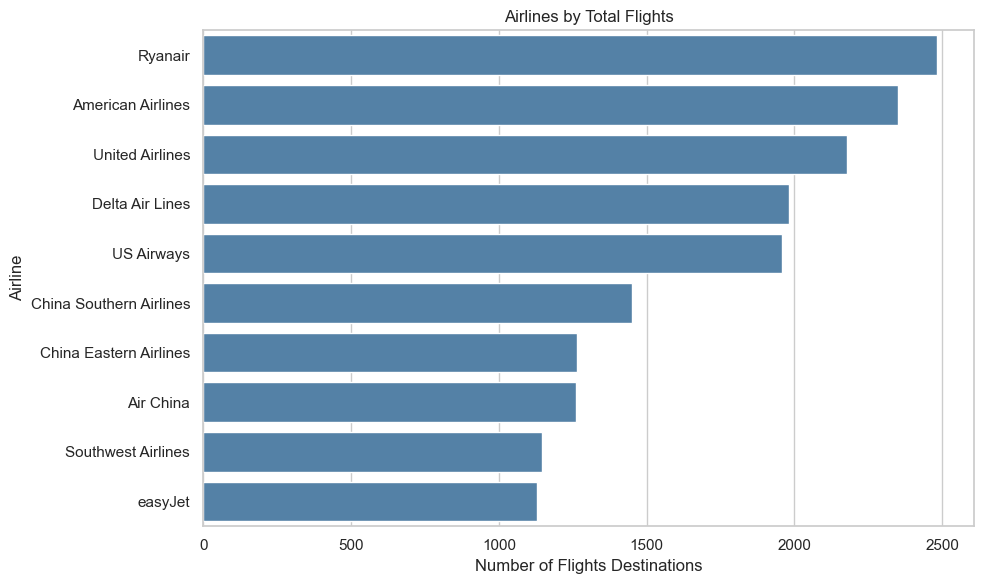

In [109]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
sns.barplot(
    data=top_airlines_by_flights.head(10),
    y='Name',
    x='Total Flights',
    color='steelblue'
)

plt.title('Airlines by Total Flights')
plt.xlabel('Number of Flights Destinations')
plt.ylabel('Airline')
plt.tight_layout()
plt.show()

Ryanair leads in sheer flight count due to its low-cost, high-frequency model, while American and United stand out in both flight volume and global reach

#### Geography (by country & continent)

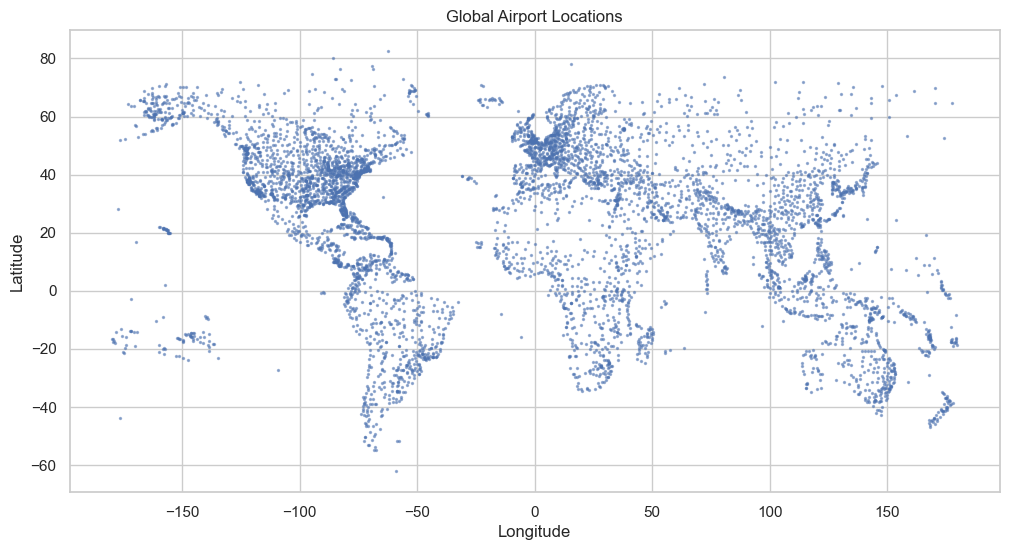

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.scatter(
    airports["Longitude"], airports["Latitude"],
    s=2, alpha=0.5
)
plt.title("Global Airport Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

The `routes` dataframe containts source airport and destination airport. `Source airport` refers to the airport from which the flight departs. It is the starting point of the journeyy. The `Destintion airport` is where the flight arrives; the endpoint of the journey. Let's look at a specific example

In [111]:
# ensure numeric IDs for safe joins
routes2 = routes.copy()
routes2['Source airport ID'] = pd.to_numeric(routes2['Source airport ID'], errors='coerce')
routes2['Destination airport ID'] = pd.to_numeric(routes2['Destination airport ID'], errors='coerce')

ap = airports[['Airport ID','IATA','Name','Country','Latitude','Longitude']].copy()
ap['Airport ID'] = pd.to_numeric(ap['Airport ID'], errors='coerce')

# attach source/destination coords
r = (routes2
     .merge(ap.add_prefix('src_'), left_on='Source airport ID', right_on='src_Airport ID', how='inner')
     .merge(ap.add_prefix('dst_'), left_on='Destination airport ID', right_on='dst_Airport ID', how='inner'))

In [112]:
R = 6371.0088  # Earth mean radius in km

lat1 = np.radians(r['src_Latitude']);  lon1 = np.radians(r['src_Longitude'])
lat2 = np.radians(r['dst_Latitude']);  lon2 = np.radians(r['dst_Longitude'])

dlat = lat2 - lat1
dlon = lon2 - lon1
a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
r['distance_km'] = 2 * R * np.arcsin(np.sqrt(a))
r['distance_mi'] = r['distance_km'] * 0.621371

In [113]:
# Keep only meaningful routes (drop self-loops, very short distances)
r_clean = r[r['Source airport'] != r['Destination airport']].copy()
r_clean = r_clean[r_clean['distance_km'] > 1]

longest_10 = (
    r_clean.sort_values('distance_km', ascending=False)
           .loc[:, [
               'Airline',
               'Source airport','src_Name','src_Country',
               'Destination airport','dst_Name','dst_Country',
               'distance_km','distance_mi'
           ]]
           .head(10)
)
longest_10

,Airline,Source airport,src_Name,src_Country,Destination airport,dst_Name,dst_Country,distance_km,distance_mi
6421,AA,SYD,Sydney Kingsford Smith International Airport,Australia,DFW,Dallas Fort Worth International Airport,United States,13808.197326,8580.013381
45870,QF,SYD,Sydney Kingsford Smith International Airport,Australia,DFW,Dallas Fort Worth International Airport,United States,13808.197326,8580.013381
20404,DL,JNB,OR Tambo International Airport,South Africa,ATL,Hartsfield Jackson Atlanta International Airport,United States,13582.606639,8439.837870
19560,DL,ATL,Hartsfield Jackson Atlanta International Airport,United States,JNB,OR Tambo International Airport,South Africa,13582.606639,8439.837870
13485,B6,DXB,Dubai International Airport,United Arab Emirates,LAX,Los Angeles International Airport,United States,13400.095537,8326.430764
22658,EK,LAX,Los Angeles International Airport,United States,DXB,Dubai International Airport,United Arab Emirates,13400.095537,8326.430764
13612,B6,LAX,Los Angeles International Airport,United States,DXB,Dubai International Airport,United Arab Emirates,13400.095537,8326.430764
22576,EK,DXB,Dubai International Airport,United Arab Emirates,LAX,Los Angeles International Airport,United States,13400.095537,8326.430764
50113,SV,LAX,Los Angeles International Airport,United States,JED,King Abdulaziz International Airport,Saudi Arabia,13389.838555,8320.057373
50067,SV,JED,King Abdulaziz International Airport,Saudi Arabia,LAX,Los Angeles International Airport,United States,13389.838555,8320.057373


In [114]:
airport_dest = (
    routes.groupby('Source airport')['Destination airport']
    .nunique()
    .reset_index(name='Unique Destinations')
    .merge(
        airports[['IATA','Country']], 
        left_on='Source airport', right_on='IATA', how='left'
    )
    .drop(columns=['IATA'])
    .rename(columns={'Source airport': 'Airport'})
)

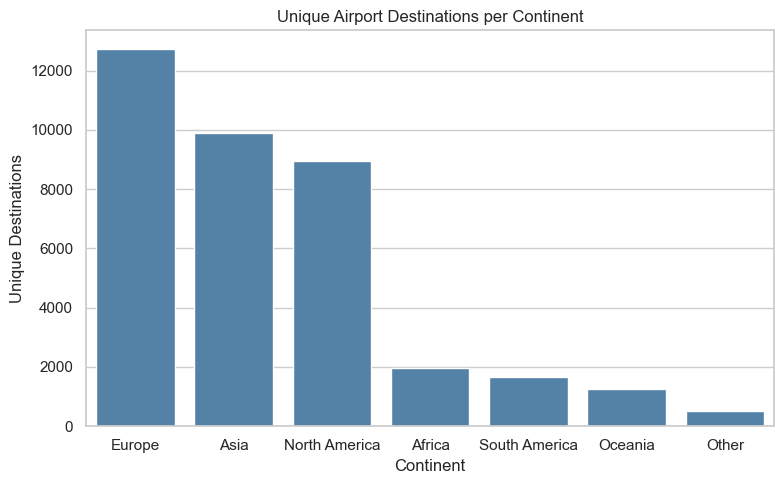

In [115]:
# Function to identify the continent for each country
def country_to_continent(name):
    try:
        a2 = pc.country_name_to_country_alpha2(name)
        code = pc.country_alpha2_to_continent_code(a2)
        return pc.convert_continent_code_to_continent_name(code)
    except:
        return "Other"

airport_dest['Continent'] = airport_dest['Country'].apply(country_to_continent)

#roll up by continent
continent_dest = (airport_dest.groupby('Continent')['Unique Destinations']
                              .sum()
                              .sort_values(ascending=False)
                              .reset_index())

plt.figure(figsize=(8,5))
sns.barplot(data=continent_dest, x='Continent', y='Unique Destinations', color="steelblue")
plt.title('Unique Airport Destinations per Continent')
plt.xlabel('Continent')
plt.ylabel('Unique Destinations')
plt.tight_layout()
plt.show()

Some airports fall into an ‘Other’ category because their country names could not be matched to a continent using the pycountry_convert library. These typically represent overseas territories, or disputed regions. The number is small compared to the main continents and does not affect overall patterns.

## Geographic Visualizations

Geographic visualizations to showcase the global flight network and connectivity patterns.

In [116]:
# Import additional libraries for mapping
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from folium import plugins
from shapely.geometry import LineString, Point
import warnings
warnings.filterwarnings('ignore')

#### Airport Connectivity Heat Map

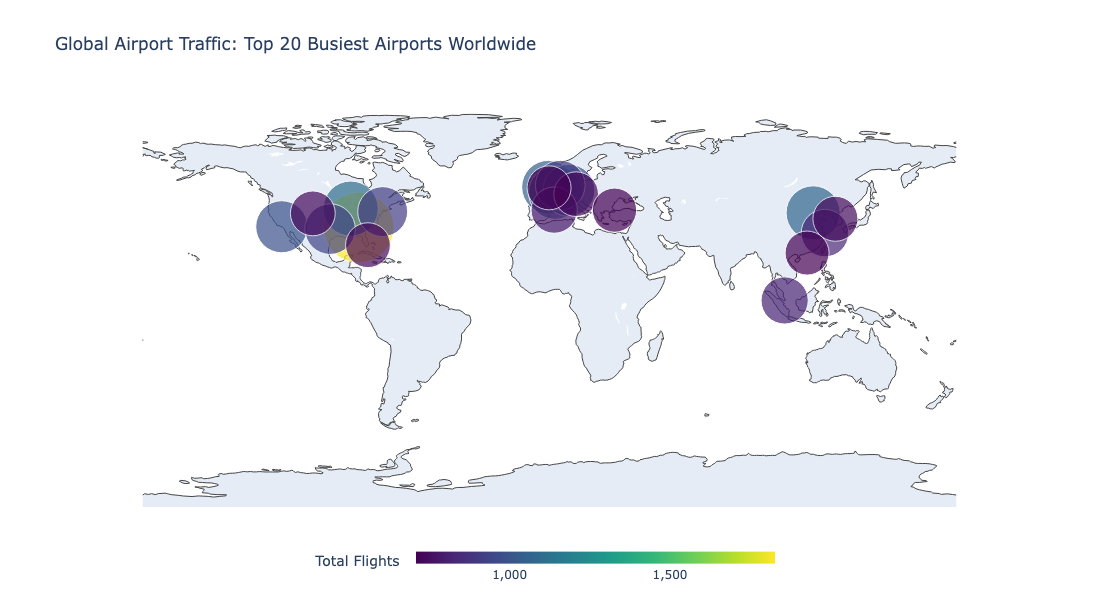

In [117]:
airport_connectivity_map = airports_flights.head(20).copy()

fig = px.scatter_geo(
    airport_connectivity_map,
    lat='Latitude',
    lon='Longitude',
    size='Total Flights',
    hover_name='Name',
    hover_data={'Country': True, 'City': True, 'Total Flights': True},
    color='Total Flights',
    color_continuous_scale='Viridis',
    size_max=50,
    title='Global Airport Traffic: Top 20 Busiest Airports Worldwide'
)

fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='equirectangular'
    ),
    width=1200,
    height=600,
    
    # fix the colorbar
    coloraxis_colorbar=dict(
        orientation='h',     # horizontal
        y=-0.2,              # push below the map
        x=0.5, xanchor='center',
        len=0.5,             # shorter bar
        thickness=12,
        title='Total Flights',
        tickformat=','       # nice thousands separators
    )
)

fig.show()

<function matplotlib.pyplot.show(close=None, block=None)>

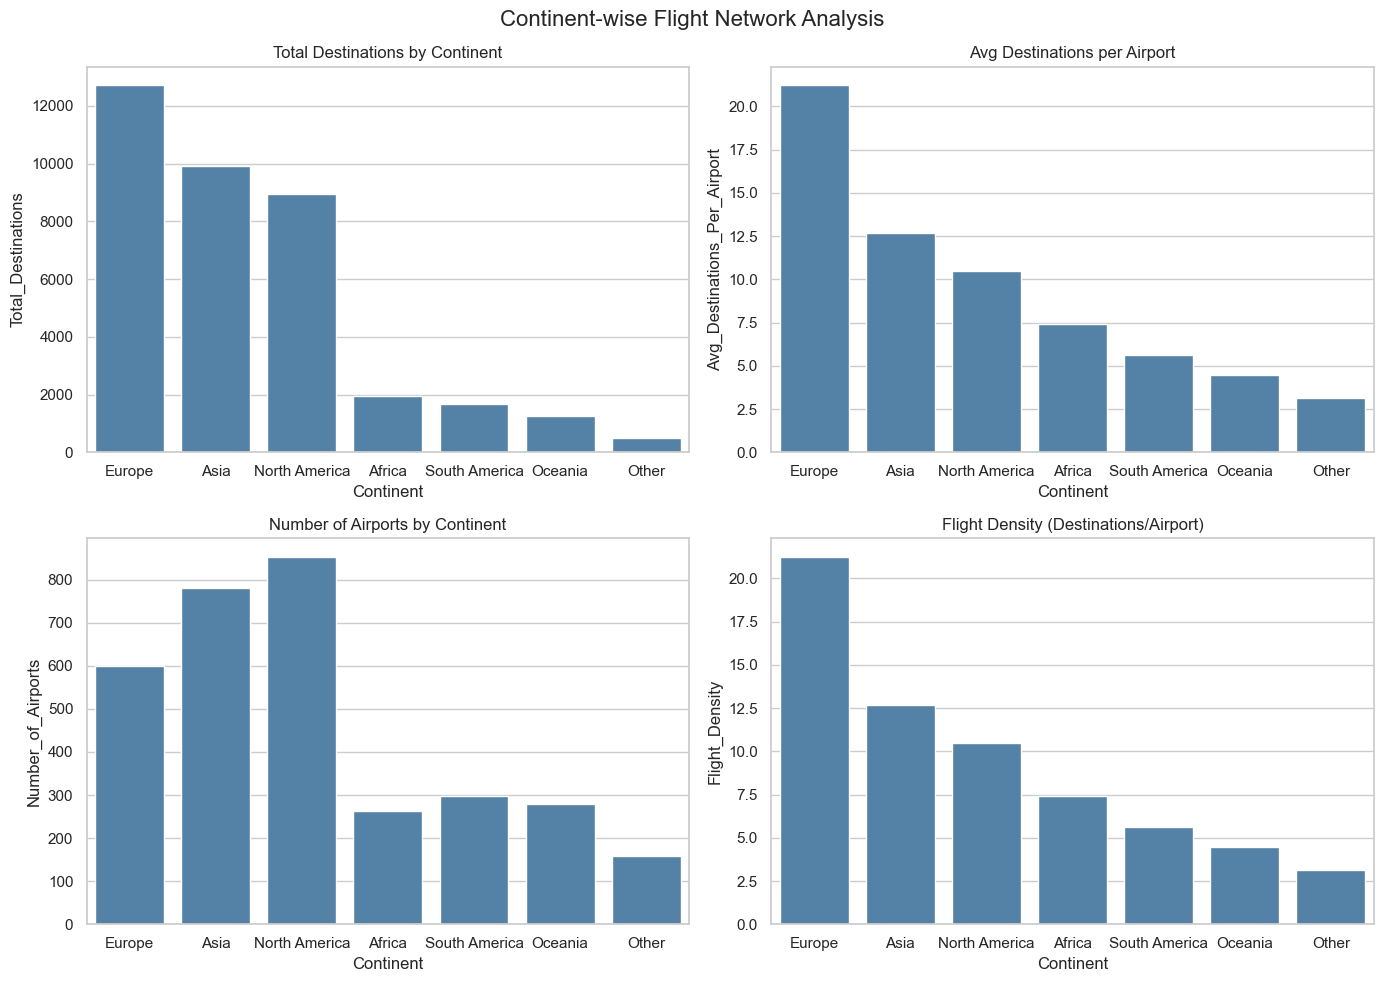

In [118]:
# Prepare the continent analysis table
continent_analysis = (
    airport_dest.groupby('Continent')
    .agg(Total_Destinations=('Unique Destinations', 'sum'),
         Avg_Destinations_Per_Airport=('Unique Destinations', 'mean'),
         Number_of_Airports=('Unique Destinations', 'count'))
    .round(2)
    .sort_values('Total_Destinations', ascending=False)
)

# Add Flight Density column
continent_analysis["Flight_Density"] = (
    continent_analysis["Total_Destinations"] / continent_analysis["Number_of_Airports"]
)

# Set Seaborn style and color
sns.set_theme(style="whitegrid")
color = "steelblue"

# Create a 2x2 grid of bar plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.barplot(data=continent_analysis, 
            x=continent_analysis.index, y="Total_Destinations", color=color, ax=axes[0,0])
axes[0,0].set_title("Total Destinations by Continent")

sns.barplot(data=continent_analysis,
            x=continent_analysis.index, y="Avg_Destinations_Per_Airport", color=color, ax=axes[0,1])
axes[0,1].set_title("Avg Destinations per Airport")

sns.barplot(data=continent_analysis, 
            x=continent_analysis.index, y="Number_of_Airports", color=color, ax=axes[1,0])
axes[1,0].set_title("Number of Airports by Continent")

sns.barplot(data=continent_analysis, 
            x=continent_analysis.index, y="Flight_Density", color=color, ax=axes[1,1])
axes[1,1].set_title("Flight Density (Destinations/Airport)")

fig.suptitle("Continent-wise Flight Network Analysis", fontsize=16)
plt.tight_layout()
plt.show

### Key Insights & Reccomendations
1. The Hartsfield–Jackson Atlanta International Airport (ATL) has the highest number of flights, showing the strength of the U.S. domestic market and its function as a door for international connections. Airlines seeking entry into the U.S should prioritize partnerships or code shares with carriers that operate through ATL to maximize coverage.
2. European hubs lead in destination diversity with London Heathrow (LHR), Paris Charles de Gaulle (CDG), and Frankfurt (FRA) connecting to the largest number of unique destinations.This shows Europe's role as a transfer point between continents. For airlines or investors, strengthening presence in these hubs offers access to diverse international markets, though competition is intense, and secondary airports in Europe may provide alternative opportunities for growth
3. The airline Ryanair leads in flight volume with its low-cost, high-frequency model dominating within Europe, while American Airlines and United Airlines balance both total flights and global coverage. Competing carriers could learn from Ryanair’s efficiency in short-haul operations, while partnerships or alliances with U.S. legacy carriers offer opportunities to expand international reach.
4. North America and Europe dominate global air travel networks, while Africa and South America remain underconnected—presenting opportunities for airlines to expand into underserved regions and for investors to support infrastructure growth, especially alongside rising demand for ultra-long-haul routes (e.g., Sydney–Dallas, Johannesburg–Atlanta, Dubai–LAX).
5. Flight density varies significantly across regions. Europe has far higher average destinations per airport compared to Asia and North America. This means European airports are more efficient and concentrated, while North America’s fragmented network shows underutilization. Airlines could focus on hub consolidation strategies in North America or invest in secondary city connectivity in Asia to unlock efficiency gains.
6. Underserved regions hold long-term growth potential.Africa, South America, and Oceania show very low connectivity relative to population and geography. While near-term profitability may be limited, these regions represent strategic long-term bets for carriers willing to capture early-mover advantage, especially as demand for tourism and regional trade grows.